In [18]:
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
import warnings
import itertools
import numpy as np
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
import sys
%matplotlib inline

sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
buy_sessions['purchase_id'] = buy_sessions['purchase_id'].astype(int)
buy_sessions['date']=buy_sessions['timestamp'].dt.date
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount','session_id','timestamp'], inplace=True)
products_per_day = buy_sessions.groupby(by=['date','product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
products_per_day['date']=pd.to_datetime(products_per_day['date'])
products_per_day['product_id'] = products_per_day['product_id'].astype(str)

In [19]:
# Jak to uruchomisz to można znaleźć ogólny trend
products_per_day['date']=pd.to_datetime(products_per_day['date'])
products_per_day['product_id'] = products_per_day['product_id'].astype(str)
products_per_day=products_per_day.groupby(by=[pd.Grouper(key='date', freq="W"),pd.Grouper(key='product_id')]).sum()
print(products_per_day)

                       amount
date       product_id        
2019-08-04 1002             3
           1003             0
           1004             0
           1005             0
           1006             1
...                       ...
2021-12-26 1310             0
           1311             0
           1312             0
           1313             0
           1314             0

[24822 rows x 1 columns]


<AxesSubplot:xlabel='date,product_id'>

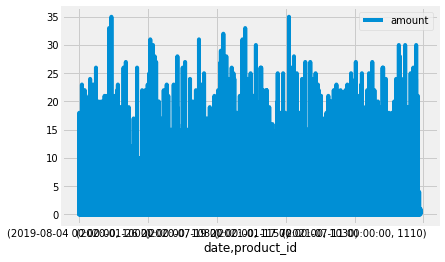

In [20]:
df.plot(y='amount',use_index=True)

In [23]:
df

amount
date       product_id        
2019-08-04 1002             3
           1003             0
           1004             0
           1005             0
           1006             1
...                       ...
2021-12-26 1310             0
           1311             0
           1312             0
           1313             0
           1314             0

[24822 rows x 1 columns]

In [24]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 53) for x in list(itertools.product(p, d, q))]

In [ ]:
best_aic=sys.maxsize
best_param=(1,1,1)
best_param_seasonal=(1,1,1,12)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            message='ARIMA{}x{}53 - AIC:{}'.format(param,param_seasonal,results.aic)
            print(message)
            if results.aic<best_aic:
                best_param=param
                best_param_seasonal=param_seasonal
                best_aic=results.aic
        except Exception as e: 
            print(str(e))
print("*****************")
print("Best parameters:")
print('ARIMA{}x{}12 - AIC:{}'.format(best_param,best_param_seasonal,best_aic))

In [ ]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=best_param,
                                seasonal_order=best_param_seasonal,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
print(df.head(10))

pred = results.get_prediction(start=pd.to_datetime('2019-08-04'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.ylim([-1,30])
plt.legend()
plt.show()

In [ ]:
pred_uc = results.get_forecast(steps=159)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [ ]:
## TUTAJ ZACZYNA SIĘ ARIMA, NIE WARTO TEGO RUSZAĆ CHYBA, CHYBA ŻE Z CIEKAWOŚCI - TEŻ PROSTA LINIA WYCHODZI

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['amount'], trace=True)

In [ ]:
cutoff_point=int(len(df)*0.2)
train=df[:-cutoff_point]
test=df[-cutoff_point:]
print(len(train))
print(len(test))
model=ARIMA(train['amount'],order=(5,0,0),freq='W')
model=model.fit()
model.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['amount'].plot(legend=True)

In [ ]:
end=len(train)+len(test)-1
pred=model.predict(start=0,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
df['amount'].plot(legend=True)